<a href="https://colab.research.google.com/github/flaviocrispin/twitter_analisys/blob/main/4_Word2Vec_e_treinamento_da_rede_neural_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec Análise e treino

---
 - Carregamento arquivos
 - Tokenização 
 - Separar dados de treino e teste
 - Construir vocabulário Word2Vec e treinar o algoritmo
 - Gráfico de palavras semelhantes
 - Gráfico t-SNE
 - Construir matrix TF-IDF
 - Construir vetores
 - Concatenar vetores
 - Treinar modelo
 - Resultado


## 1. Carregar e importar dados

In [1]:
#@title Conectar google colab com  google drive

from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title Importar bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pd.options.mode.chained_assignment = None


import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from pprint import pprint

import spacy


from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
from nltk import word_tokenize

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
#from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.models import model_from_json


# importing bokeh library for interactive dataviz
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

import warnings
warnings.filterwarnings("ignore")

In [3]:
PATH_FOLDER = '/content/drive/MyDrive/Colab Notebooks/project_politics' #@param {type: 'string'}
PATH_IMAGES = '/content/drive/MyDrive/Colab Notebooks/project_politics/img/' #@param {type: 'string'}
PATH_MODELS = '/content/drive/MyDrive/Colab Notebooks/project_politics/models/' #@param {type: 'string'}
PATH_DATA = '/content/drive/MyDrive/Colab Notebooks/project_politics/data/' #@param {type: 'string'}


In [4]:
#@title Carregar DATASETS
df1 = pd.read_csv(PATH_DATA +  'interim' + '/bolsonaro_tratado_sentiment.csv', sep=';')
df2 = pd.read_csv(PATH_DATA +  'interim' + '/lula_tratado_sentiment.csv', sep=';')
df3 = pd.read_csv(PATH_DATA +  'interim' + '/ciro_tratado_sentiment.csv', sep=';')

## 2. Classificação usando Word2Vec

In [7]:
#@title Tokenização dos tweets

tokenizer = TweetTokenizer()


def tokenize (tweet):
  try:
    tokens = tokenizer.tokenize(tweet)
    return tokens
  except:
    return 'NC'

def postprocess(data):
  data['tokens'] = data['cleaned_tweet'].progress_map(tokenize)
  data = data[data.tokens != 'NC']
  data.reset_index(inplace=True)
  data.drop('index', inplace=True, axis=1)
  return data 


candidate = 'Ciro' #@param ["Bolsonaro", "Lula", "Ciro"]

if candidate == 'Bolsonaro':
  df_b = postprocess(df1)

if candidate == 'Lula':
  df_l= postprocess(df2)

if candidate == 'Ciro':
  df_c = postprocess(df3)
  
#@markdown Determinar de números de DIM e Epochs
n_dim = 200 #@param {type: 'integer'}
epochs = 10 #@param {type: 'integer'}

progress-bar: 100%|██████████| 207555/207555 [00:16<00:00, 12229.47it/s]


In [16]:
#@title Separar dados de treino e teste
LabeledSentence = gensim.models.doc2vec.LabeledSentence # we'll talk about this down below
def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

#training and test split the datasets
x_train_b, x_test_b, y_train_b, y_test_b = train_test_split(np.array(df_b.tokens),
                                                    np.array(df_b.Sentiment), test_size=0.3)

x_train_l, x_test_l, y_train_l, y_test_l = train_test_split(np.array(df_l.tokens),
                                                    np.array(df_l.Sentiment), test_size=0.3)

x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(np.array(df_c.tokens),
                                                    np.array(df_c.Sentiment), test_size=0.3)



x_train_b = labelizeTweets(x_train_b, 'TRAIN')
x_test_b = labelizeTweets(x_test_b, 'TEST')

x_train_l = labelizeTweets(x_train_l, 'TRAIN')
x_test_l = labelizeTweets(x_test_l, 'TEST')

x_train_c = labelizeTweets(x_train_c, 'TRAIN')
x_test_c = labelizeTweets(x_test_c, 'TEST')



data_labellised_b = labelizeTweets(np.array(df_b.tokens), 'data')
data_labellised_l = labelizeTweets(np.array(df_l.tokens), 'data')
data_labellised_c = labelizeTweets(np.array(df_c.tokens), 'data')




0it [01:39, ?it/s]


23331it [00:00, 233293.54it/s]

49066it [00:00, 247436.84it/s]

73810it [00:00, 240604.87it/s]

100942it [00:00, 252520.44it/s]

127373it [00:00, 256719.93it/s]

153072it [00:01, 74712.92it/s] 

177268it [00:01, 95288.07it/s]

203228it [00:01, 119848.20it/s]

229431it [00:01, 144865.80it/s]

255631it [00:01, 168394.07it/s]

281882it [00:01, 189377.65it/s]

307860it [00:01, 206382.62it/s]

333968it [00:02, 220412.71it/s]

360460it [00:02, 232347.48it/s]

387857it [00:02, 243873.69it/s]

414112it [00:02, 243203.21it/s]

439738it [00:03, 77081.07it/s] 

483749it [00:03, 141773.71it/s]
207321it [00:00, 263295.01it/s]
454530it [00:02, 181140.56it/s]
194799it [00:01, 108721.55it/s]
145064it [00:00, 280149.03it/s]
62171it [00:00, 279719.25it/s]
691070it [00:03, 201679.93it/s]
649329it [00:03, 190198.03it/s]
207235it [00:00, 310626.06it/s]


In [9]:
#@title Construir vocabulário e treino

tweet_w2v_b = Word2Vec(size=n_dim)
tweet_w2v_b.build_vocab([x.words for x in tqdm(data_labellised_b)])
tweet_w2v_b.train([x.words for x in tqdm(data_labellised_b)], total_examples=tweet_w2v_b.corpus_count, epochs=epochs)
print ('Training Bolsonaro completed')
print ('---------------')

tweet_w2v_l = Word2Vec(size=n_dim)
tweet_w2v_l.build_vocab([x.words for x in tqdm(data_labellised_l)])
tweet_w2v_l.train([x.words for x in tqdm(data_labellised_l)], total_examples=tweet_w2v_l.corpus_count, epochs=epochs)
print ('Training Lula completed')
print ('---------------')

tweet_w2v_c = Word2Vec(size=n_dim)
tweet_w2v_c.build_vocab([x.words for x in tqdm(data_labellised_c)])
tweet_w2v_c.train([x.words for x in tqdm(data_labellised_c)], total_examples=tweet_w2v_c.corpus_count, epochs=epochs)
print ('Training Ciro completed')
print ('---------------')

100%|██████████| 691070/691070 [00:00<00:00, 3075265.50it/s]


Training Bolsonaro completed
---------------


100%|██████████| 649329/649329 [00:00<00:00, 3120040.35it/s]


Training Lula completed
---------------


100%|██████████| 207235/207235 [00:00<00:00, 2943848.48it/s]


Training Ciro completed
---------------


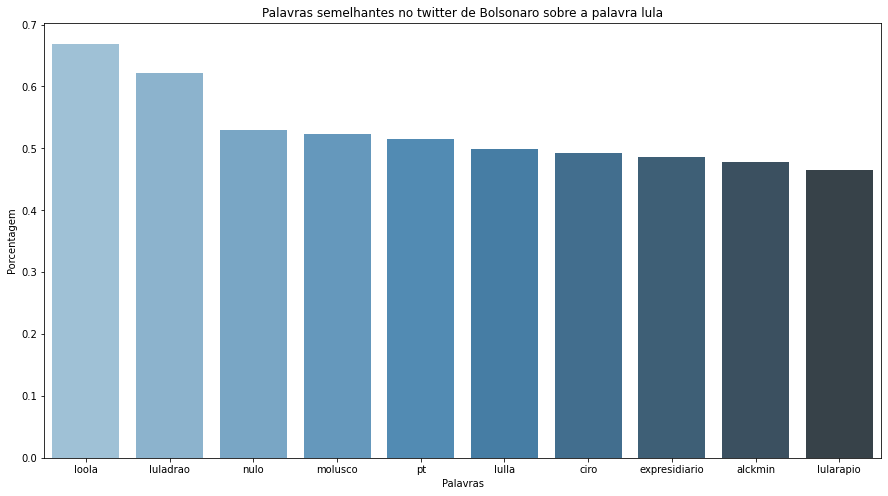

In [36]:
#@title Palavras semelhantes
#@markdown  Escolha o candidato e a palavra semelhante

candidato = 'Bolsonaro' #@param ["Bolsonaro", "Lula", "Ciro"]
Palavra = 'lula' #@param {type:'string'}
Salvar = True #@param {type:"boolean"}

def similar_words (data, word, save_file, candidate):
  similar = data.most_similar(word)
  plt.figure(figsize = (15,8))
  series = pd.Series(data=[v for k, v in similar], index=[k for k, v in similar], name='')
  plt.title('Palavras semelhantes no twitter de {} sobre a palavra {}'.format (candidate, word))
  ax = sns.barplot(series.index, series.values,
              palette="Blues_d")
  ax.set_xlabel('Palavras')
  ax.set_ylabel('Porcentagem')
  if save_file:
    plt.savefig(PATH_IMAGES + '{}_similar_words_about_{}_graphic.png'.format (candidate, word))
  plt.show()

  return 



if candidato == 'Bolsonaro':
  similar_words(tweet_w2v_b, Palavra, Salvar, candidato)

if candidato == 'Lula':
  similar_words(tweet_w2v_l, Palavra, Salvar, candidato)

if candidato == 'Ciro':
  similar_words(tweet_w2v_c, Palavra, Salvar, candidato)


In [10]:
#@title Save the Word2Vec model
tweet_w2v_b.save(PATH_MODELS + '/w2vmodel_bolsonaro.model')
tweet_w2v_l.save(PATH_MODELS + '/w2vmodel_lula.model')
tweet_w2v_c.save(PATH_MODELS + '/w2vmodel_ciro.model')

In [8]:
#@title Load the Word2Vec model
tweet_w2v_b = Word2Vec.load(PATH_MODELS + '/w2vmodel_bolsonaro.model')
tweet_w2v_l = Word2Vec.load(PATH_MODELS + '/w2vmodel_lula.model')
tweet_w2v_c = Word2Vec.load(PATH_MODELS + '/w2vmodel_ciro.model')

In [ ]:
#@title t-SNE chart
def similar_words_graphic (data, name):
  output_notebook()
  plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
                          tools="pan,wheel_zoom,box_zoom,reset,hover,save",
                          x_axis_type=None, y_axis_type=None, min_border=1)

  # getting a list of word vectors. limit to 10000. each is of 200 dimensions
  word_vectors = [data[w] for w in list(data.wv.vocab.keys())[:5000]]

  # dimensionality reduction. converting the vectors to 2d vectors
  from sklearn.manifold import TSNE
  tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
  tsne_w2v = tsne_model.fit_transform(word_vectors)

  # putting everything in a dataframe
  tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
  tsne_df['words'] = list(data.wv.vocab.keys())[:5000]

  # plotting. the corresponding word appears when you hover on the data point.
  plot_tfidf.scatter(x='x', y='y', source=tsne_df)
  hover = plot_tfidf.select(dict(type=HoverTool))
  hover.tooltips={"word": "@words"}
  plt.savefig (PATH_IMAGES + '{}_similar_words_graphic.png'.format (name))
  show(plot_tfidf)

candidate = 'Bolsonaro' #@param ["Bolsonaro", "Lula", "Ciro", "Moro"]

if candidate == 'Bolsonaro':
  name = 'bolsonaro'
  similar_words_graphic(tweet_w2v_b, name)

if candidate == 'Lula':
  name = 'lula'
  similar_words_graphic(tweet_w2v_l, name)

if candidate == 'Ciro':
  name = 'ciro'
  similar_words_graphic(tweet_w2v_c, name)
  
if candidate == 'Moro':
  name = 'moro'
  similar_words_graphic(tweet_w2v_m, name)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.003s...
[t-SNE] Computed neighbors for 5000 samples in 1.560s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.640743
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.514030
[t-SNE] KL divergence after 1000 iterations: 2.805921


<Figure size 432x288 with 0 Axes>

## 3. Training the model

In [19]:
#@title Construir matrix TF-IDF

def tf_idf_create (candidate):
  vectorizer = TfidfVectorizer(analyzer=lambda x: x)
  matrix = vectorizer.fit_transform([x.words for x in candidate])
  result = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
  return result

candidate = 'Ciro' #@param ["Bolsonaro", "Lula", "Ciro"]

if candidate == 'Bolsonaro':
  nome = 'Bolsonaro'
  print ('building tf-idf matrix for {}'.format (nome))
  tfidf = tf_idf_create(data_labellised_b)
  print (('vocab size :', len(tfidf)))

if candidate == 'Lula':
  nome = 'Lula'
  print ('building tf-idf matrix for {}'.format (nome))
  tfidf = tf_idf_create(data_labellised_l)
  print (('vocab size :', len(tfidf)))

if candidate == 'Ciro':
  nome = 'Ciro'
  print ('building tf-idf matrix for {}'.format (nome))
  tfidf = tf_idf_create(data_labellised_c)
  print (('vocab size :', len(tfidf)))

building tf-idf matrix for Ciro
('vocab size :', 72246)


In [20]:
#@title Construir palavra vetor
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v_b[word].reshape((1, size)) * tfidf[word] #combining w2v vectors with tfidf value of words in the tweet.
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [17]:
#@title Concatenar vetores

def training_model (train_model, test_model):
  train = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, train_model))])
  train = scale(train)

  test = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, test_model))])
  test = scale(test)
  return train, test


candidate = 'Ciro' #@param ["Bolsonaro", "Lula", "Ciro"]

if candidate == 'Bolsonaro':
  nome = 'Bolsonaro'
  print ('concatenando o modelo para {}'.format (nome))
  train_vecs_w2v_b, test_vecs_w2v_b = training_model(x_train_b, x_test_b)

if candidate == 'Lula':
  nome = 'Lula'
  print ('concatenando o modelo para {}'.format (nome))
  train_vecs_w2v_l, test_vecs_w2v_l = training_model(x_train_l, x_test_l)

if candidate == 'Ciro':
  nome = 'Ciro'
  print ('concatenando o modelo para {}'.format (nome))
  train_vecs_w2v_c, test_vecs_w2v_c = training_model(x_train_c, x_test_c)

concatenando o modelo para Ciro


145064it [00:25, 5731.78it/s]
62171it [00:09, 6564.38it/s]


In [20]:
#@title Treinando o modelo
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=n_dim))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

def dl_training (train_vec, train, epocas):
  
  return model.fit(train_vec, train, epochs=epocas, batch_size=10000, verbose=2)

candidate = 'Ciro' #@param ["Bolsonaro", "Lula", "Ciro"]
Epochs = 10 #@param {type: 'integer'}

if candidate == 'Bolsonaro':
  nome = 'Bolsonaro'
  print ('Training the model for {}'.format (nome))
  model_b = dl_training(train_vecs_w2v_b, y_train_b, Epochs)

if candidate == 'Lula':
  nome = 'Lula'
  print ('Training the model for {}'.format (nome))
  model_l = dl_training(train_vecs_w2v_l, y_train_l, Epochs)

if candidate == 'Ciro':
  nome = 'Ciro'
  print ('Training the model for {}'.format (nome))
  model_c = dl_training(train_vecs_w2v_c, y_train_c, Epochs)


Training the model for Ciro
Epoch 1/10
15/15 - 1s - loss: 0.5066 - accuracy: 0.8036 - 1s/epoch - 81ms/step
Epoch 2/10
15/15 - 0s - loss: 0.2854 - accuracy: 0.9030 - 138ms/epoch - 9ms/step
Epoch 3/10
15/15 - 0s - loss: 0.1837 - accuracy: 0.9033 - 134ms/epoch - 9ms/step
Epoch 4/10
15/15 - 0s - loss: 0.1321 - accuracy: 0.9033 - 128ms/epoch - 9ms/step
Epoch 5/10
15/15 - 0s - loss: 0.0906 - accuracy: 0.9034 - 150ms/epoch - 10ms/step
Epoch 6/10
15/15 - 0s - loss: 0.0406 - accuracy: 0.9034 - 128ms/epoch - 9ms/step
Epoch 7/10
15/15 - 0s - loss: -2.5773e-02 - accuracy: 0.9039 - 120ms/epoch - 8ms/step
Epoch 8/10
15/15 - 0s - loss: -1.1304e-01 - accuracy: 0.9044 - 122ms/epoch - 8ms/step
Epoch 9/10
15/15 - 0s - loss: -2.2278e-01 - accuracy: 0.9047 - 140ms/epoch - 9ms/step
Epoch 10/10
15/15 - 0s - loss: -3.6535e-01 - accuracy: 0.9047 - 108ms/epoch - 7ms/step


### Resultados

In [ ]:
#@title Avaliando acurácia do modelo

def score (test_vec, test):
  score = model.evaluate(test_vec, test, batch_size=128, verbose=2)
  print(model.metrics_names[0],": ",score[0],"\n",model.metrics_names[1],": ",score[1])
  return score

  


candidate = 'Ciro' #@param ["Bolsonaro", "Lula", "Ciro"]

if candidate == 'Bolsonaro':
  name = 'Bolsonaro'
  print ('Accuracy the model for {}'.format (name))
  score_b = score(test_vecs_w2v_b, y_test_b)

if candidate == 'Lula':
  name = 'Lula'
  print ('Accuracy the model for {}'.format (name))
  score_l = score(test_vecs_w2v_l, y_test_l)

if candidate == 'Ciro':
  name = 'Ciro'
  print ('Accuracy the model for {}'.format (name))
  score_c = score(test_vecs_w2v_c, y_test_c)

Accuracy the model for Ciro
289/289 - 1s - loss: -6.7278e-01 - accuracy: 0.9114 - 595ms/epoch - 2ms/step
loss :  -0.6727846264839172 
 accuracy :  0.9114201664924622


In [23]:
#@title Saving model
def saving_model (test_vec, name):
  test_vec = model.to_json() # serialize model to JSON
  with open(PATH_MODELS + 'model_{}.json'.format (name), "w") as json_file:
      json_file.write(test_vec)

  print("Modelo salvo no google drive")

#Loading the model
# newmodel = model_from_json(open('model.json').read())
# newmodel.load_weights('smodel.h5')

candidato = 'Ciro' #@param ["Bolsonaro", "Lula", "Ciro"]

if candidato == 'Bolsonaro':
  nome = 'Bolsonaro'
  saving_model(test_vecs_w2v_b, candidato)

if candidato == 'Lula':
  nome = 'Lula'
  saving_model(test_vecs_w2v_l, candidato)

if candidato == 'Ciro':
  nome = 'Ciro'
  saving_model(test_vecs_w2v_c, candidato)

Modelo salvo no google drive


In [11]:
#@title Carregar modelo treinado
def load_model (nome):
  newmodel = model_from_json(open(PATH_MODELS + 'model_{}.json'.format(nome)).read())
  # newmodel.load_weights('smodel.h5')
  print ('Modelo sobre {} carregado com sucesso'.format(nome))
  return newmodel

candidato = 'Ciro' #@param ["Bolsonaro", "Lula", "Ciro"]

if candidato == 'Bolsonaro':
  model_b = load_model(candidato)

if candidato == 'Lula':
  model_l = load_model(candidato)

if candidato == 'Ciro':
  model_c = load_model(candidato)

Modelo sobre Ciro carregado com sucesso


In [23]:
# query_b=np.array(df1.tokens)
# query_w2v_vecs_b = np.concatenate([buildWordVector(z, 200) for z in tqdm(map(lambda x:x, query_b))])

# query_l=np.array(df2.tokens)
# query_w2v_vecs_l = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x:x, query_l))])

query_c=np.array(df3.tokens)
query_w2v_vecs_c = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x:x, query_c))])

207555it [00:33, 6222.09it/s]


In [31]:
#training the model
result_b = model_b.predict(query_w2v_vecs_b)
result_l = model_l.predict(query_w2v_vecs_l)
result_c = model_c.predict(query_w2v_vecs_c )

In [32]:
#@title Criar novo DATASET com nova análise de sentimentos
def create_new_df (result, data):
  resultado = pd.DataFrame(result)
  df = pd.concat([data, resultado], axis=1)
  df_data = df.rename(columns={0: 'sentiment_DL'})
  df_data.loc[df_data['sentiment_DL'] > 0, 'sentimentos'] = 'positivo'
  df_data.loc[df_data['sentiment_DL'] <= 0, 'sentimentos'] = 'negativo'
  return df_data

candidate = 'Ciro' #@param ["Bolsonaro", "Lula", "Ciro"]

if candidate == 'Bolsonaro':
  name = 'Bolsonaro'
  new_df_b = create_new_df (result_b, df1)

if candidate == 'Lula':
  name = 'Lula'
  new_df_l = create_new_df (result_l, df2)

if candidate == 'Ciro':
  name = 'Ciro'
  new_df_c = create_new_df (result_c, df3)



In [33]:
#@title Salvar DATASETS no google drive

new_df_b.to_csv(PATH_DATA + 'interim' + '/bolsonaro_dataframe_master.csv', sep=';', index=False)
print ('the sentiment analisy for the BOLSONARO dataset has saved in {}interim/'.format (PATH_DATA))
print ('----------------')

new_df_l.to_csv(PATH_DATA + 'interim' + '/lula_dataframe_master.csv', sep=';', index=False)
print ('the sentiment analisy for the LULA dataset has saved in {}interim/'.format (PATH_DATA))
print ('----------------')


new_df_c.to_csv(PATH_DATA + 'interim' + '/ciro_dataframe_master.csv', sep=';', index=False)
print ('the sentiment analisy for the CIRO dataset has saved in {}interim/'.format (PATH_DATA))

the sentiment analisy for the CIRO dataset has saved in /content/drive/MyDrive/Colab Notebooks/project_politics/data/interim/
